In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/pufr_fixed_ttbar/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_idx_sig = f["jet_ttbar_match"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)
    event_label_sig = np.ones(len(jet_pt_sig))

# Load background sample into memory
with uproot.open("ntuples/pufr_fixed_ttbar/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_idx_bkg = f["jet_ttbar_match"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)
    event_label_bkg = np.zeros(len(jet_pt_bkg))

In [3]:
# crazy vectorized syntax https://awkward-array.org/doc/main/user-guide/how-to-restructure-concatenate.html#emulating-numpy-s-stack-functions
jet_sig = ak.concatenate([jet_pt_sig[:, :, np.newaxis], jet_eta_sig[:, :, np.newaxis], jet_phi_sig[:, :, np.newaxis], jet_m_sig[:, :, np.newaxis], jet_pufr_sig[:, :, np.newaxis], jet_label_sig[:, :, np.newaxis]], axis=2)
jet_bkg = ak.concatenate([jet_pt_bkg[:, :, np.newaxis], jet_eta_bkg[:, :, np.newaxis], jet_phi_bkg[:, :, np.newaxis], jet_m_bkg[:, :, np.newaxis], jet_pufr_bkg[:, :, np.newaxis], jet_label_bkg[:, :, np.newaxis]], axis=2)

# combine sig and bkg into one vector
jet_feats = ak.concatenate([jet_sig, jet_bkg], axis=0)
event_labels = np.concatenate([event_label_sig,event_label_bkg], axis=0)

In [4]:
#shuffled_idx = np.random.permutation(len(jet_feats))
#jet_feats = jet_feats[shuffled_idx]
#event_labels = event_labels[shuffled_idx]

sig = (event_labels==1)    
bkg = ~sig

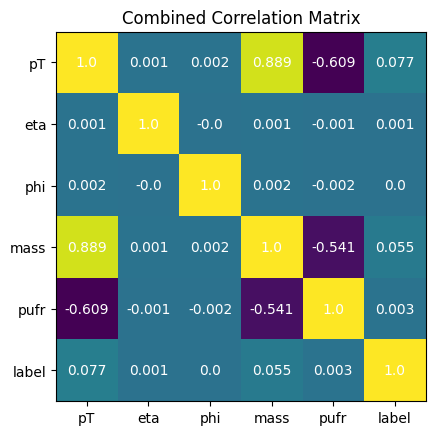

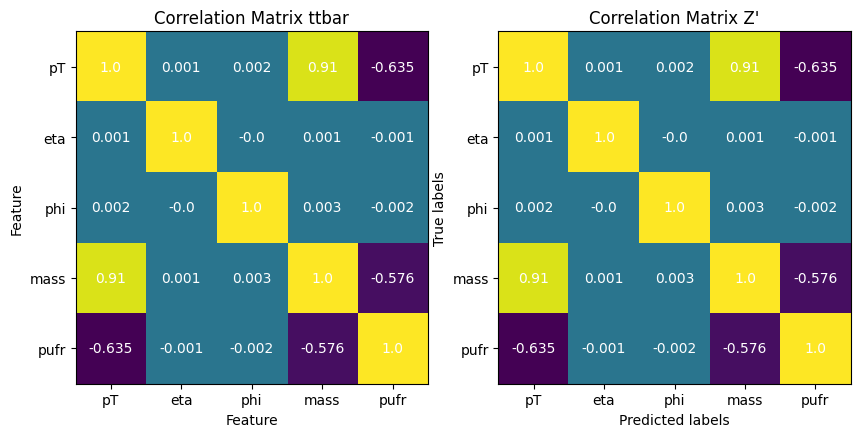

In [5]:
#######################################
### Combined Correlation with Label ###
#######################################
corr_list = []
num_feats = len(jet_feats[0][0])
for i in range(num_feats):
    for j in range(num_feats):
        corr_list.append(ak.corr(jet_feats[:,:,i],jet_feats[:,:,j]))
corr_matrix = np.array(corr_list).reshape(num_feats,num_feats)
plt.imshow(corr_matrix)
plt.title("Combined Correlation Matrix")
for i in range(num_feats):
    for j in range(num_feats):
        plt.text(j, i, str(round(corr_matrix[i, j],3)), ha='center', va='center', color='white')
plt.xticks(np.arange(6), ['pT', 'eta', 'phi', 'mass','pufr','label'])
plt.yticks(np.arange(6), ['pT', 'eta', 'phi', 'mass','pufr','label'])
plt.show()

##################################
### Split Correlation by Label ###
##################################
corr_list_sig = []
corr_list_bkg = []
num_feats = len(jet_feats[0][0])-1
for i in range(num_feats):
    for j in range(num_feats):
        corr_list_sig.append(ak.corr(jet_feats[sig][:,:,i],jet_feats[sig][:,:,j]))
        corr_list_bkg.append(ak.corr(jet_feats[bkg][:,:,i],jet_feats[bkg][:,:,j]))
corr_matrix_sig = np.array(corr_list_sig).reshape(num_feats,num_feats)
corr_matrix_bkg = np.array(corr_list_sig).reshape(num_feats,num_feats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(corr_matrix_sig)
ax1.set_title("Correlation Matrix ttbar")
#ax1.set_colorbar()
ax1.set_xticks(np.arange(5), ['pT', 'eta', 'phi', 'mass','pufr'])
ax1.set_yticks(np.arange(5), ['pT', 'eta', 'phi', 'mass','pufr'])
for i in range(num_feats):
    for j in range(num_feats):
        ax1.text(j, i, str(round(corr_matrix_sig[i, j],3)), ha='center', va='center', color='white')
ax1.set_xlabel("Feature")
ax1.set_ylabel("Feature")
ax2.imshow(corr_matrix_bkg)
ax2.set_title("Correlation Matrix Z\'")
#ax2.colorbar()
ax2.set_xticks(np.arange(5), ['pT', 'eta', 'phi', 'mass','pufr'])
ax2.set_yticks(np.arange(5), ['pT', 'eta', 'phi', 'mass','pufr'])
for i in range(num_feats):
    for j in range(num_feats):
        ax2.text(j, i, str(round(corr_matrix_bkg[i, j],3)), ha='center', va='center', color='white')
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
plt.show()